# (TITLE)

# Introduction

Pulsars are high-energy neutron stars that emit beams of electromagnetic radiation through their magnetic poles in regular pulses. They rotate on an axis at defining speeds. In our particular data set, the HTRU2 Data Set, which describes a sample of pulsar candidates, we are discussing 8 main variables that describe each pulse/emitted energy at a time. The first 4 variables are from the integrated pulse profile and the last 4 are from the DM-SNR Curve. Integrated Pulse Profile is the integrated signal sent by the pulsar considered with respect to rotational period. DM-SNR Curves are curves used to describe pulsars considering their frequency, phase, time and sound to noise ratio. The question we are answering is: **Which of a pulsar candidate's characteristics best indicates whether it is a pulsar star or not?**

# Methods and Results

The dataset can be read from the web to R and tidied as follows:

In [52]:
library(tidyverse)
library(tidymodels)
library(parallel)
htru_data <- read_csv(
    "https://github.com/Bruce0517/dsci-100-2022w1-group-160/raw/main/HTRU_2.csv", 
    col_names = c("p.mean", "p.sd", "p.kurt", "p.skew",
                  "c.mean", "c.sd", "c.kurt", "c.skew", "class")) |>
    mutate(class = ifelse(class == 1, "Pulsar", "Non-pulsar")) |>
    mutate(class = as_factor(class))

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): p.mean, p.sd, p.kurt, p.skew, c.mean, c.sd, c.kurt, c.skew, class

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The data did not have column names, so column names needed to be added. The class name was then made more human-readable and made a factor, to make data analysis easier.

The data is a description of data gathered from pulsar candidates. Here is a sample of some pulsars and non-pulsars:

In [54]:
set.seed(69420)
bind_rows(sample_n(filter(htru_data, class == "Non-pulsar"), 3),
          sample_n(filter(htru_data, class == "Pulsar"), 3))

p.mean,p.sd,p.kurt,p.skew,c.mean,c.sd,c.kurt,c.skew,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
100.14844,41.15787,0.6187296,1.5244102,1.732441,16.48696,12.498927,168.368092,Non-pulsar
110.16406,40.31318,0.5820537,0.7071917,3.343645,18.43795,8.038802,81.182894,Non-pulsar
131.17969,48.99863,0.0702603,-0.1755943,14.413880,43.49945,3.073368,8.639341,Non-pulsar
100.39844,39.28369,0.3695178,0.9012783,2.649666,21.38761,8.520892,74.554360,Pulsar
58.78906,33.07724,2.8263069,15.0398616,17.257525,54.34239,3.192879,9.012004,Pulsar
65.78125,45.98946,2.5732238,7.6958315,18.548495,52.68814,3.005062,8.190395,Pulsar


The data is then separated into training and testing sets:

In [55]:
set.seed(69420)

# Proportion is low to lower memory usage and computing time later
htru_split <- initial_split(htru_data, prop = .5, strata = class)  
htru_train <- training(htru_split)   
htru_test <- testing(htru_split)

Here is the number of pulsars and non-pulsars in the training set and the average for each variable:

In [56]:
htru_train |>
    group_by(class) |>
    summarize(n = n(), p.mean = mean(p.mean), p.sd = mean(p.sd), p.kurt = mean(p.kurt), p.skew = mean(p.skew),
                       c.mean = mean(c.mean), c.sd = mean(c.sd), c.kurt = mean(c.kurt), c.skew = mean(c.skew))

class,n,p.mean,p.sd,p.kurt,p.skew,c.mean,c.sd,c.kurt,c.skew
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Non-pulsar,8135,116.55383,47.24958,0.2095486,0.3907247,8.708427,23.30529,8.840782,113.11916
Pulsar,814,57.99119,38.74257,3.0810694,15.2339659,49.386423,56.25237,2.721068,16.65216


The `na.rm = TRUE` argument was not required in `mean`, meaning that there are no missing values to handle. The following is a histogram for each variable from a sample of 500 of each class, to compare the distributions of the predictor variables:

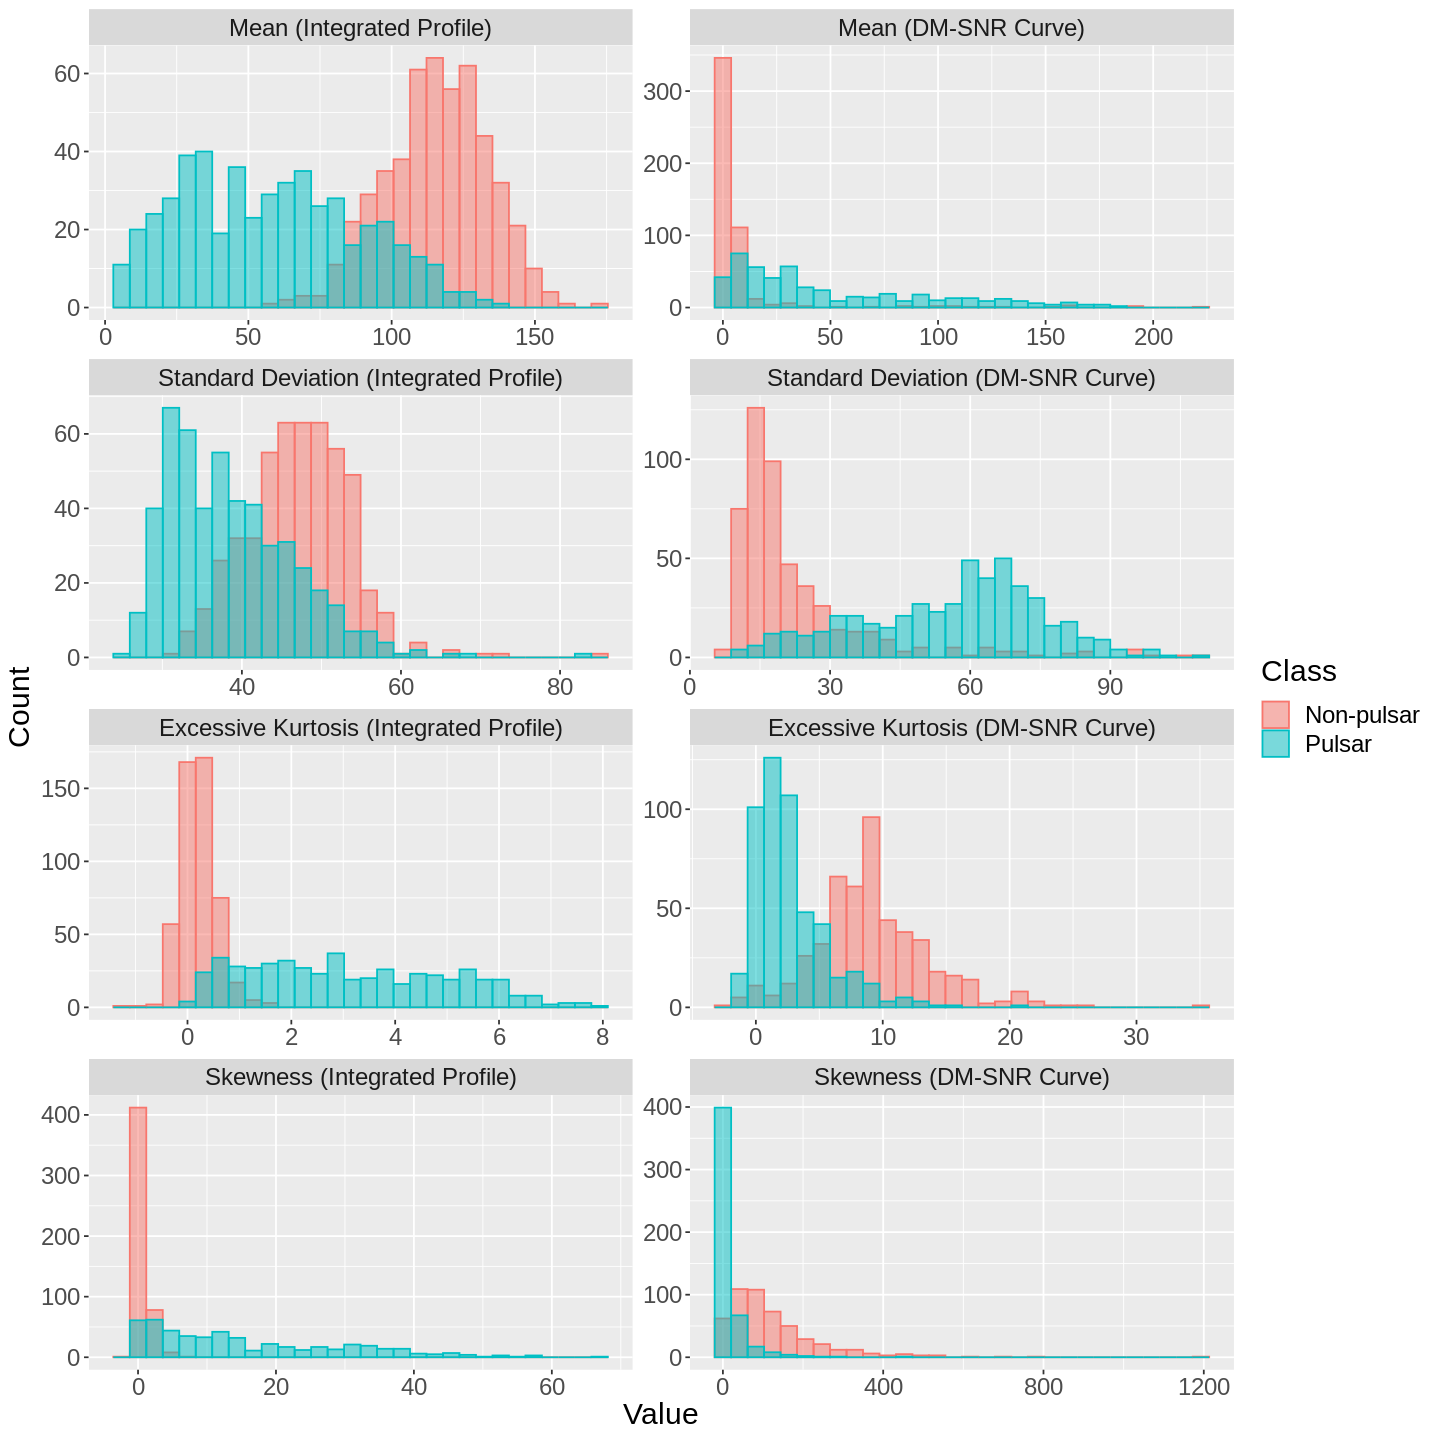

In [57]:
options(repr.plot.width=12, repr.plot.height=12)
set.seed(69420)

factor_levels <- c("p.mean", "c.mean", "p.sd", "c.sd", "p.kurt", "c.kurt", "p.skew", "c.skew")
untidy <- function(data) {  # To plot the data we must first untidy it
    data |>
    pivot_longer(-class, names_to = "preds", values_to = "vals") |> 
    mutate(preds = factor(preds, levels = factor_levels))
}
pulsar_sample <- untidy(filter(htru_train, class == "Non-pulsar") |> sample_n(500))
non_pulsar_sample <- untidy(filter(htru_train, class == "Pulsar") |> sample_n(500))
histo_data <- bind_rows(pulsar_sample, non_pulsar_sample)
facet_labels <- c("p.mean" = "Mean (Integrated Profile)", 
                  "p.sd" = "Standard Deviation (Integrated Profile)", 
                  "p.kurt" = "Excessive Kurtosis (Integrated Profile)", 
                  "p.skew" = "Skewness (Integrated Profile)",
                  "c.mean" = "Mean (DM-SNR Curve)", 
                  "c.sd" = "Standard Deviation (DM-SNR Curve)", 
                  "c.kurt" = "Excessive Kurtosis (DM-SNR Curve)", 
                  "c.skew" = "Skewness (DM-SNR Curve)")

ggplot(histo_data, aes(x = vals, fill = as_factor(class), color = as_factor(class))) +
    geom_histogram(alpha = 0.5, position = "identity", bins = 30) +
    facet_wrap(vars(preds), nrow = 4, ncol = 2,
               scales = "free", 
               labeller = as_labeller(facet_labels)) +
    labs(x = "Value", y = "Count", fill = "Class", color = "Class") +
    theme(text = element_text(size=18))

The plots show that most values do not have a significant overlap between classes, and thus patterns can be identified in the data which will support further analysis of this data done to answer the question.

To conduct the data analysis required to answer the devised question, all of the variables are used. Importantly, the class variable indicates whether the candidate is a pulsar or not; the remaining variables describe important and unique properties of the candidates. The data analysis is be conducted using classification, which allows prediction of the class for a pulsar candidate. The methodology for this data analysis is to test and train models of the data for each of the numerical variables, to determine which variable is most accurate in predicting the class of pulsar candidates. 

This data will be visualized in various ways to ensure its implications can be communicated. One way the results will be visualized will be through bar plots, which could be used for the comparison of accuracies.

Specifically, k-nearest neighbors (KNN) classification is used. However, scaling is unnecessary as only one variable is used. First, 8 recipes are created for 8 of the variables:

In [58]:
pm_recipe <- recipe(class ~ p.mean, data = htru_train)
cm_recipe <- recipe(class ~ c.mean, data = htru_train)
pd_recipe <- recipe(class ~ p.sd, data = htru_train)
cd_recipe <- recipe(class ~ c.sd, data = htru_train)
pk_recipe <- recipe(class ~ p.kurt, data = htru_train)
ck_recipe <- recipe(class ~ c.kurt, data = htru_train)
ps_recipe <- recipe(class ~ p.skew, data = htru_train)
cs_recipe <- recipe(class ~ c.skew, data = htru_train)

Then, a model for determining the number of neighbors for maximum accuracy and a vfold for the entire HTRU training data set is created:

In [59]:
set.seed(69420)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

htru_vfold <- vfold_cv(htru_train, v = 5, strata = class)

#cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
#       geom_point() +
#       geom_line() +
#       labs(x = "Neighbors", y = "Accuracy Estimate") +
#       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
#       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

#cross_val_plot

Then, the accuracy for each combination of number of neighbors and variable is calculated and combined into a table, then it is plotted for easier visualization:    
(Warning: The code cell below should take about 5 minutes to execute)

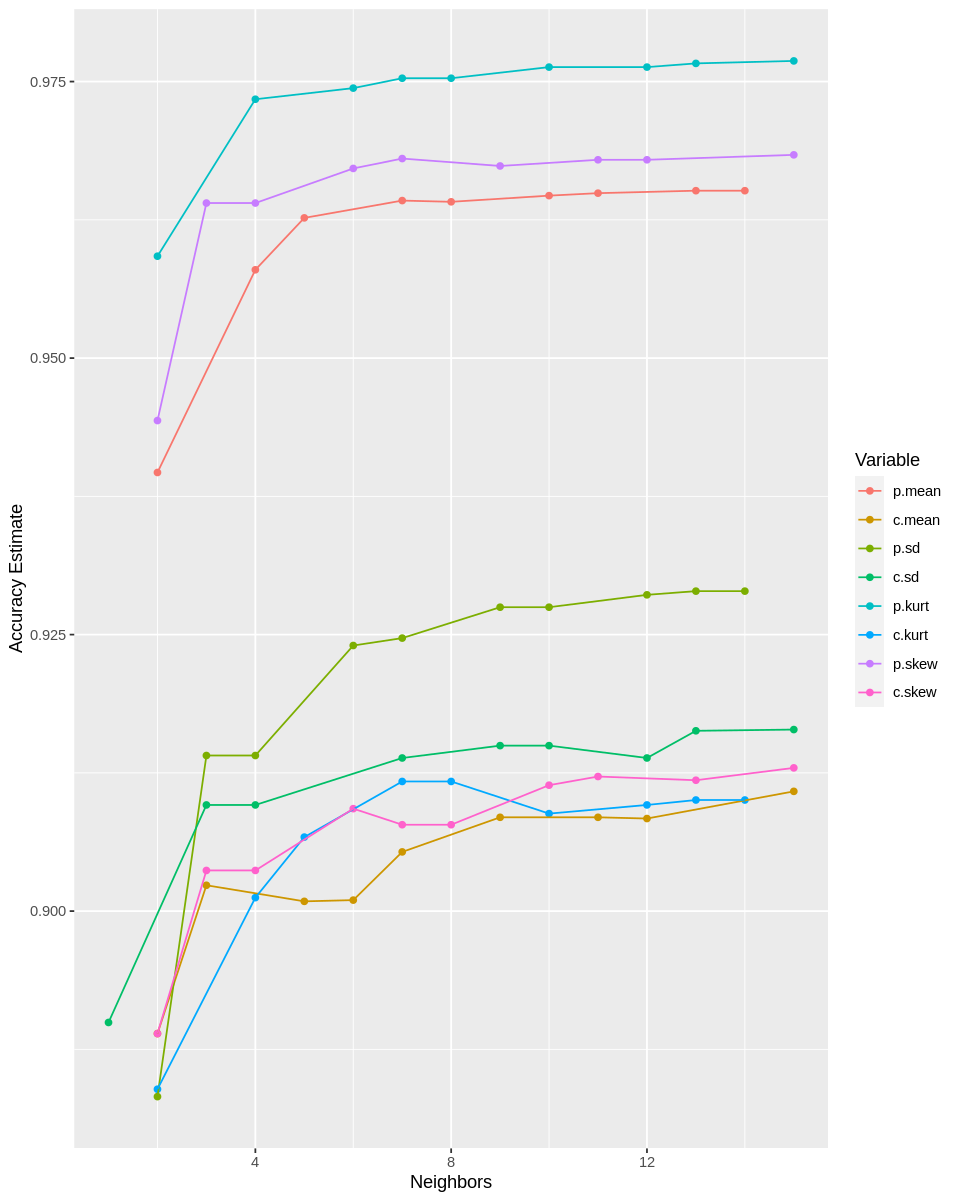

In [60]:
options(repr.plot.width = 8, repr.plot.height = 10)

knn_accuracies <- function(recipe) {
  workflow() |>
    add_recipe(recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = htru_vfold, grid = 10) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)
}

recipes <- list(pm_recipe, cm_recipe, pd_recipe, cd_recipe,
                pk_recipe, ck_recipe, ps_recipe, cs_recipe)


results <- lapply(recipes, knn_accuracies)
  
factor_levels <- c("p.mean", "c.mean", "p.sd", "c.sd", "p.kurt", "c.kurt", "p.skew", "c.skew")

named_results <- bind_rows(mutate(results[[1]], variable = "p.mean"),
                           mutate(results[[2]], variable = "c.mean"),
                           mutate(results[[3]], variable = "p.sd"),
                           mutate(results[[4]], variable = "c.sd"),
                           mutate(results[[5]], variable = "p.kurt"),
                           mutate(results[[6]], variable = "c.kurt"),
                           mutate(results[[7]], variable = "p.skew"),
                           mutate(results[[8]], variable = "c.skew")) |> 
                 mutate(preds = factor(variable, levels = factor_levels))


cross_val_plot <- ggplot(named_results, aes(x = neighbors, y = mean, color = as_factor(variable))) +
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate", color = "Variable")

cross_val_plot

This is *not* the result of our data analysis, as this is only based on training data. However, it does allow a good K-value to be picked. by visual inspection, the ideal values for K would be:
| Variable                                 | No. of neighbors |
|:-----------------------------------------|-----------------:|
| Mean of Integrated Profile               |                9 |
| Mean of DM-SNR Curve                     |               13 |
| Standard Deviation of Integrated Profile |               13 |
| Standard Deviation of DM-SNR Curve       |               13 |
| Excessive Kurtosis of Integrated Profile |                9 |
| Excessive Kurtosis of DM-SNR Curve       |                7 |
| Skewness of Integrated Profile           |                7 |
| Skewness of DM-SNR Curve                 |               11 |

Some lower numbers have been chosen deliberately to avoid overfitting.

So, these k-values are then put into different models:

In [61]:
knn_spec_7 <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
              set_engine("kknn") |>
              set_mode("classification")
knn_spec_9 <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
              set_engine("kknn") |>
              set_mode("classification")
knn_spec_11 <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
               set_engine("kknn") |>
               set_mode("classification")
knn_spec_13 <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
               set_engine("kknn") |>
               set_mode("classification")

Then, Different workflows for the different variables are created:

In [62]:
# Surely a built-in function like this exists?
htru_fit <- function(recipe, model) {
    workflow() |>
    add_recipe(recipe) |>
    add_model(model) |>
    fit(data = htru_train)
}

pm_fit <- htru_fit(pm_recipe, knn_spec_9)
cm_fit <- htru_fit(cm_recipe, knn_spec_13)
pd_fit <- htru_fit(pd_recipe, knn_spec_13)
cd_fit <- htru_fit(cd_recipe, knn_spec_13)
pk_fit <- htru_fit(pk_recipe, knn_spec_9)
ck_fit <- htru_fit(ck_recipe, knn_spec_7)
ps_fit <- htru_fit(ps_recipe, knn_spec_7)
cs_fit <- htru_fit(cs_recipe, knn_spec_11)

Finally, these different workflows are used to predict the testing set and their accuracy are measured and plotted on a bar chart:

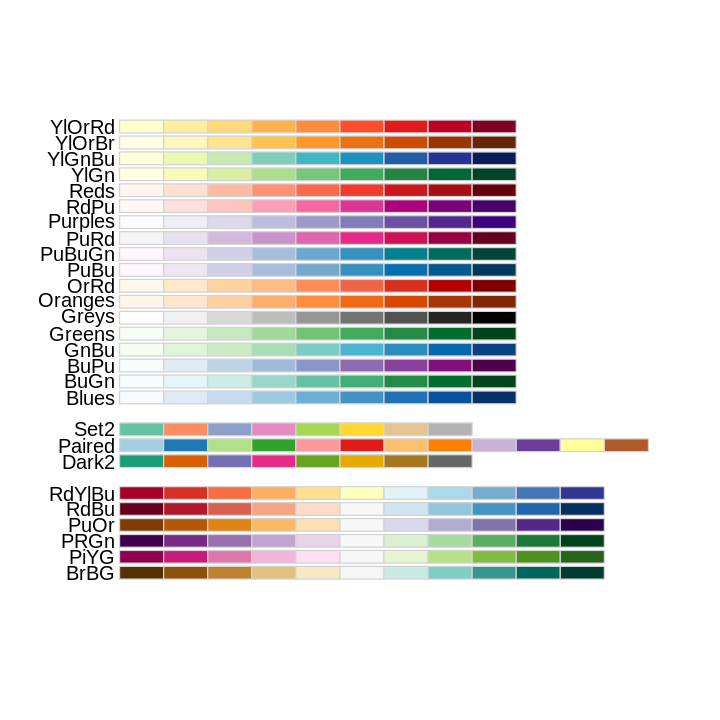

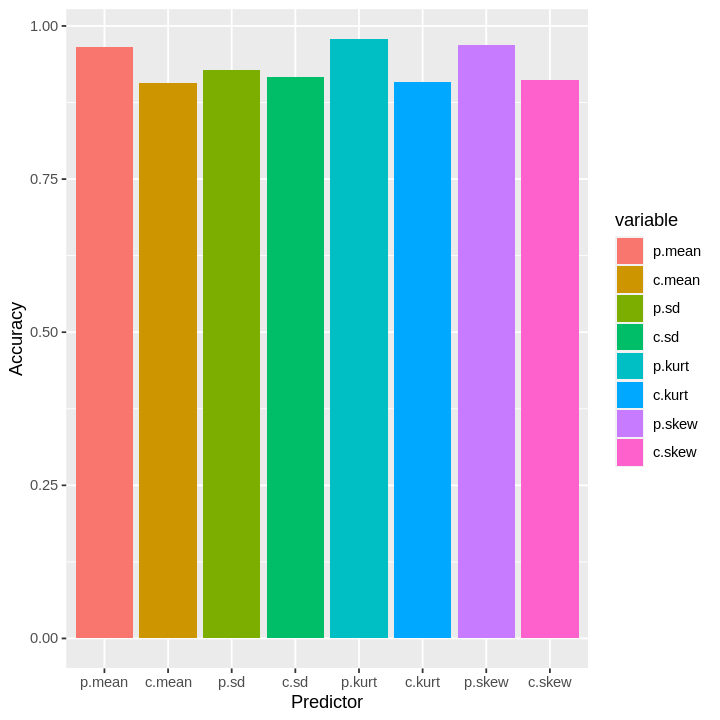

In [64]:
options(repr.plot.width = 6, repr.plot.height = 6)
library(RColorBrewer)
display.brewer.all(colorblindFriendly = TRUE)

# I left the parallel computation bits in because I'm lazy
fits <- list(pm_fit, cm_fit, pd_fit, cd_fit,
             pk_fit, ck_fit, ps_fit, cs_fit)

measure_accuracy <- function(fit) {
    predict(fit, htru_test) |>
    bind_cols(select(htru_test, class)) |>
    metrics(truth = class, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    rename(accuracy = .estimate)
}

accuracies <- lapply(fits, measure_accuracy)

factor_levels <- c("p.mean", "c.mean", "p.sd", "c.sd", "p.kurt", "c.kurt", "p.skew", "c.skew")

named_accuracies <- bind_rows(mutate(accuracies[[1]], variable = "p.mean"),
                              mutate(accuracies[[2]], variable = "c.mean"),
                              mutate(accuracies[[3]], variable = "p.sd"),
                              mutate(accuracies[[4]], variable = "c.sd"),
                              mutate(accuracies[[5]], variable = "p.kurt"),
                              mutate(accuracies[[6]], variable = "c.kurt"),
                              mutate(accuracies[[7]], variable = "p.skew"),
                              mutate(accuracies[[8]], variable = "c.skew")) |> 
                    mutate(variable = factor(variable, levels = factor_levels))

accuracies_plot <- ggplot(named_accuracies, aes(x = variable, y = accuracy)) +
                   geom_col(aes(fill = variable)) +
                   labs(x = "Predictor", y = "Accuracy") +
                   scale_color_brewer(palette = "Set2")
accuracies_plot
# Unfortunately geom_col doesn't like starting from a non-zero number
# if I want it to I'd have to do some wizardry

This seems to suggest the mean value, excessive kurtosis and skewness of the integrated profile is the best predictor for a pulsar.

# Expected Outcomes and Significance (REPLACE WITH DISCUSSIONS)

From the preliminary data analysis, it is apparent that the numerical variables have notable differences in their distributions; which indicates that it is likely a sound conclusion will be made from the data analysis. It is expected that there will not be a clear result that will not need its limitations to be discussed thoroughly. From the preliminary data analysis, there is no hypothesis that can be made with a great deal of confidence.

It is unlikely that the findings of our data analysis will be ground-breaking and have implications on the communities of learners and teachers that are closely engaged with the minutia surrounding astronomical bodies. However, our findings will definitely have the impact of enforcing the idea that data science can influence our underst anding of the way nature behaves with itself. These findings can lead to future questions about the significance of applying new ideas to pre existing understandings to create more opportunities for breakthroughs in the way humans interact with nature.


# References

...